In [3]:
import numpy 
import pylab 
import pandas 
%matplotlib inline

The `landmark_faces.txt` file on the Blackboard page has the locations in 2D of 68 landmark positions on 9780 faces. In this tutorial you are going to use PCA to transform these points, and feed the input into a classifier to predict the gender of each face. 

Start by downloading the data and loading it into a dataframe.

In [6]:
df = pandas.read_csv('../../res/data/landmark_faces.txt', header=None, delimiter=' ')

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,1_0_2_20161219140530307.jpg,-4,71,-4,96,-3,120,-1,144,9,...,136,130,135,108,139,98,140,88,139,NaN
1,1_0_2_20161219140525218.jpg,13,76,13,96,15,117,18,137,25,...,137,121,141,102,141,94,142,85,143,NaN
2,1_0_2_20161219140540938.jpg,11,62,14,84,18,105,23,127,33,...,135,135,136,109,147,99,148,90,146,NaN
3,6_1_2_20161219140554092.jpg,36,66,34,86,38,108,45,129,54,...,140,120,154,104,168,97,167,92,166,NaN
4,1_1_2_20161219140604000.jpg,-3,60,-3,85,-1,110,3,134,12,...,137,126,141,109,153,98,154,88,153,NaN


For now, we will simply extract the locations for each landmark. They are stored as $x_1 y_1 x_2 y_2 \ldots x_{68} y_{68}$ in columns 1 to 136 of the dataframe. Extract them into a data array, remove the first and last columns (the filename and the last column, which is blank), and make sure that numpy knows that the data are floating point numbers.

In [9]:
data = df.to_numpy()
data = data[:,1:-1]  #column 1 to end

data = data.astype(float)

Get the size of the data array, and store the relevant information in variables `nfaces` and `npoints` (they should be 9780 and 136 respectively).

In [11]:
row_size, col_size = numpy.shape(data)

n_faces = row_size
n_points = col_size

To plot a face, take one row of the data matrix, and plot the $x$ coordinates (even-numbered indices) against $y$ coordinates (odd-numbered ones). It is helpful to use `'.-'` to plot a line as well as the points. At first this will be upside down. One way to turn it the right way up is to use 1-data on the $y$ coordinates.

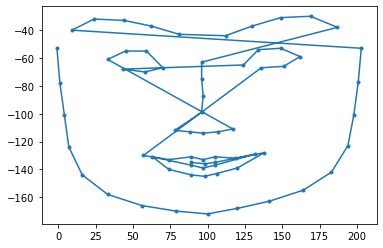

In [12]:
i = 5
x = data[i, 0::2]
y = 1 - data[i, 1::2]
pylab.plot(x, y, '.-')

The points are all meant to be matched on each face (the jargon for this is that they are 'corresponding points'). This means that to find the mean face (the average face, not a nasty-looking face) you just compute the mean of each datapoint. Compute this and plot it.

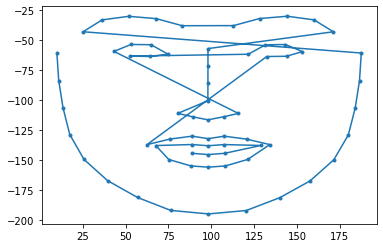

In [15]:
mean_face = numpy.mean(data, axis=0)
x = mean_face[0::2]
y = 1 - mean_face[1::2]
pylab.plot(x, y, '.-')

We've made the PCA algorithm a lot. Here it is again for your use. 

In [17]:
# Here is PCA

# Subtract off the mean
data = data - mean_face

# Compute the covariance matrix
C = np.cov(data.T)

# Get the eigenvalues and eigenvectors
evals,evecs = np.linalg.eig(C)

# Now need to sort them into descending order
indices = np.argsort(evals)
indices = indices[::-1]
evecs = evecs[:,indices]
evals = evals[indices]

# Transform the data
newdata = np.dot(evecs.T,data.T).T

Compute the scree plot of the principal components and see how many you think might be useful.

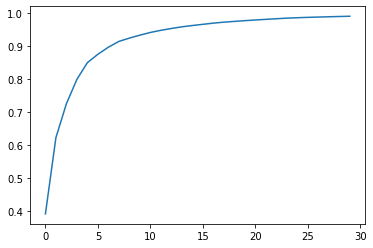

In [20]:
evals_sum = numpy.sum(evals)
evals_cumsum = numpy.cumsum(evals)
evals_cumsum_to_30 = evals_cumsum[:30]

pylab.plot(evals_cumsum_to_30/evals_sum)

Reconstruct a face from the dataset using different numbers of dimensions, and plot both the original and reconstructed face. Use this to decide how many principal components you actually need. As a hint, here is the code to reconstruct the original data. You simply need to reduce the size of the eigenvector matrix appropriately in order to reconstruct lower-dimensional versions of it.

In [22]:
newdata = numpy.dot(evecs.T, data.T).T
y = numpy.transpose(numpy.dot(evecs, newdata.T)) + mean_face

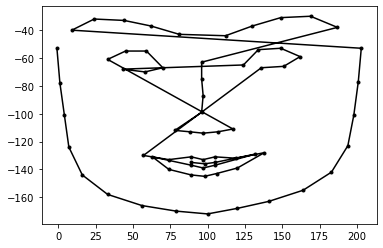

In [23]:
x = y[i,0::2]
y = 1 - y[i,1::2]
pylab.plot(x, y, 'k.-')

The next code computes some a set of shapes. Look at the code, and explain what it is doing in a couple of sentences below. 

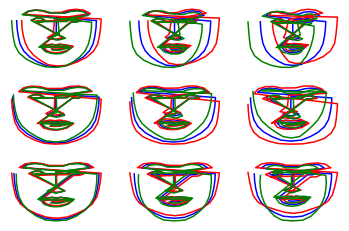

In [49]:
for pc in range(3):
    for sd in range(1,4):
        pl.subplot(3,3,pc*3+sd);
        pl.plot(meanface[0::2],1-meanface[1::2],'b')
        pl.plot(meanface[0::2] - np.sqrt(evals[pc])*sd*evecs[0::2,pc],1 - (meanface[1::2] - np.sqrt(evals[pc])*sd*evecs[1::2,pc]),'r') 
        pl.plot(meanface[0::2] + np.sqrt(evals[pc])*sd*evecs[0::2,pc],1 - (meanface[1::2] + np.sqrt(evals[pc])*sd*evecs[1::2,pc]),'g')         
        pl.axis('off')

To get training labels, look at the names of the images (which are in df[:,0]). The names are age_gender_race_date.jpg. We are interested in the gender, which is 0 or 1 for male and female (I'm not sure which is which, and it doesn't matter). Extract that digit (`stringname.find()` might be helpful, where stringname is a variable) and store it as the target variable. There is one error in the data, which is index 8513. I think you should assign it to category 0. 

In [25]:
y = numpy.zeros(n_faces)

for i in range(n_faces):
    gender = df.loc[i,0]
    first = gender[:].find('_')
    y[i] = gender[first+1]
y[8513] = 0

Now use a classification algorithm such as Support Vector Classifier from sklearn to classify the faces based on (i) the original data, and (ii) some small number of principal components. You should compare both the accuracy and time to train. Don't forget to split the data into training and testing. You probably won't understand the algorithm, but remember that sklearn guides you through the fit, predict cycle. Of course, you might be able to get better results when you understand the method, but for now we will just use it. 

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

test_prob = 0.25
x = data

X_train, X_text, y_train, y_test = train_test_split(x, y, test_size=test_prob)

x = newdata[:,:ndim]
X_train2, X_test2, y_train2, y_test2 = train_test_split(x, y, test_size=test_prob)

NameError: name 'ndim' is not defined

In [ ]:
import time

svc = SVC(gamma='auto')
t = time.time()
svc.fit(X_train, y_train)

y_predictions = svc.predict(X_test)
time_interval = time.time() - t

svc2 = SVC(gamma='auto')
t = time.time()
svc2.fit(X_train2, y_train2)
y2_predictions = svc2.predict(X_test2)
time_interval = time.time() - t

In [ ]:
from sklearn.metrics import confusion_matrix
result = confusion_matrix(y_test, y_predictions)

result2 = confusion_matrix(y_test2, y2_predictions)